# Example Bayesian SED modeling of galaxy spectra using `provabgs`
In this notebook, I will demonstrate how you can conduct Bayesian SED modeling using `provabgs` in less than 10 lines of code and in 10 minutes. 

In [1]:
import numpy as np 
from provabgs import util as UT
from provabgs import infer as Infer
from provabgs import models as Models
from provabgs import flux_calib as FluxCalib

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## 1. Load in "observed" spectra
First, lets load in an example galaxy spectrum at $z = 0.1$

In [3]:
w_obs, f_obs = np.loadtxt('spectra.dat', skiprows=1, unpack=True, usecols=[0, 1])

Text(0, 0.5, 'Flux')

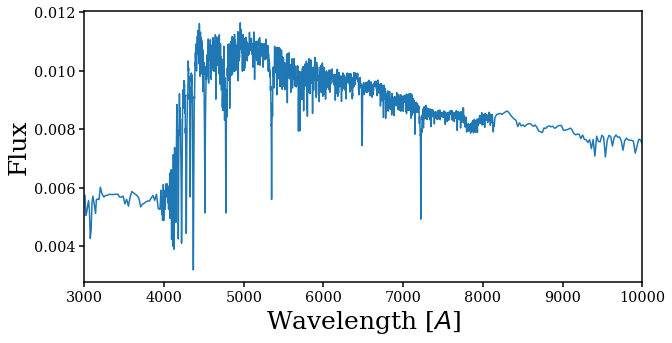

In [4]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(w_obs, f_obs)
sub.set_xlabel('Wavelength [$A$]', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('Flux', fontsize=25)

## 2. Bayesian SED modeling
To conduct Bayesian SED modeling with `provabgs`, you need to specify the following: 
1. the stellar population synthesis (SPS) model
2. the prior distribution over the free parameters of the SPS model 
3. posterior sampler

For [1], we will use the SPS model from [Hahn_et al. (2022b)](https://ui.adsabs.harvard.edu/abs/2022arXiv220201809H/abstract), which is one of the built in SPS models of the `provabgs` package. Here you can specify whether you want to use the emulator. If you set `emulator=False`, then the SPS model will use FSPS to evaluate each SSP --- this is >100x slower!

In [5]:
# declare SPS model
m_nmf = Models.NMF(burst=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


The print statement lists the 12 free parameters of the SPS model:
* `logmstar`: log stellar mass
* `beta1_sfh`, ..., `beta4_sfh`: coefficients for the 4 SFH NMF bases 
* `fburst`: fraction of total stellar mass formed during starburst event
* `tburst`: time of starburst event
* `gamma1_zh`, `gamma2_zh`: coefficients for the 2 ZH HMF bases
* `dust1`: birth cloud optical depth
* `dust2`: diffuse dust ISM optical depth
* `dust_index`: dust index

For [2], we will use uniformative priors similar to the one from [Hahn_et al. (2022b)](https://ui.adsabs.harvard.edu/abs/2022arXiv220201809H/abstract)

In [6]:
# declare prior
prior = Infer.load_priors([
    Infer.UniformPrior(7., 12.5, label='sed'),
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1., label='sed'), # burst fraction
    Infer.UniformPrior(1e-2, 13.27, label='sed'), # tburst
    Infer.LogUniformPrior(4.5e-5, 1.5e-2, label='sed'), # log uniform priors on ZH coeff
    Infer.LogUniformPrior(4.5e-5, 1.5e-2, label='sed'), # log uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2., 1., label='sed')    # uniform priors on dust_index
])

**That's it**! We're now ready to derive some posteriors! We'll use the [`zeus`](https://github.com/minaskar/zeus) ensemble slice sampler (see also https://arxiv.org/abs/2002.06212 and https://arxiv.org/abs/2105.03468)

In [8]:
# MCMC object
mcmc = Infer.specphotoMCMC(model=m_nmf, prior=prior)

chain = mcmc.run(
        wave_obs=w_obs, # observed wavelength
        flux_obs=f_obs, # observed flux of spectrum
        flux_ivar_obs=np.ones(len(f_obs)), # no noise in this example
        zred=0.1,       # redshift
        vdisp=0.,       # velocity dispersion (set to 0 for simplicity)
        sampler='zeus', # zeus ensemble slice sample
        nwalkers=30,    # number of MCMC walkers
        burnin=500,     # burn in iterations 
        opt_maxiter=2000, # maximum number of iterations for initial optimizer
        niter=3000,     # number of iterations after burn in
        progress=True)  # show progress bar

Initialising ensemble of 30 walkers...
Sampling progress : 100%|██████████| 3500/3500 [10:57<00:00,  5.32it/s]


In [13]:
chain['mcmc_chain'].shape

(3000, 30, 12)

(3000 iterations) x (30 walkers) x (12 parameters)

## 3. Posterior!
Lets first take a look at what the posteriors look like. We'll use `corner` to visualize the posterior

In [9]:
# !pip install corner # if you dont' have corner
import corner as DFM

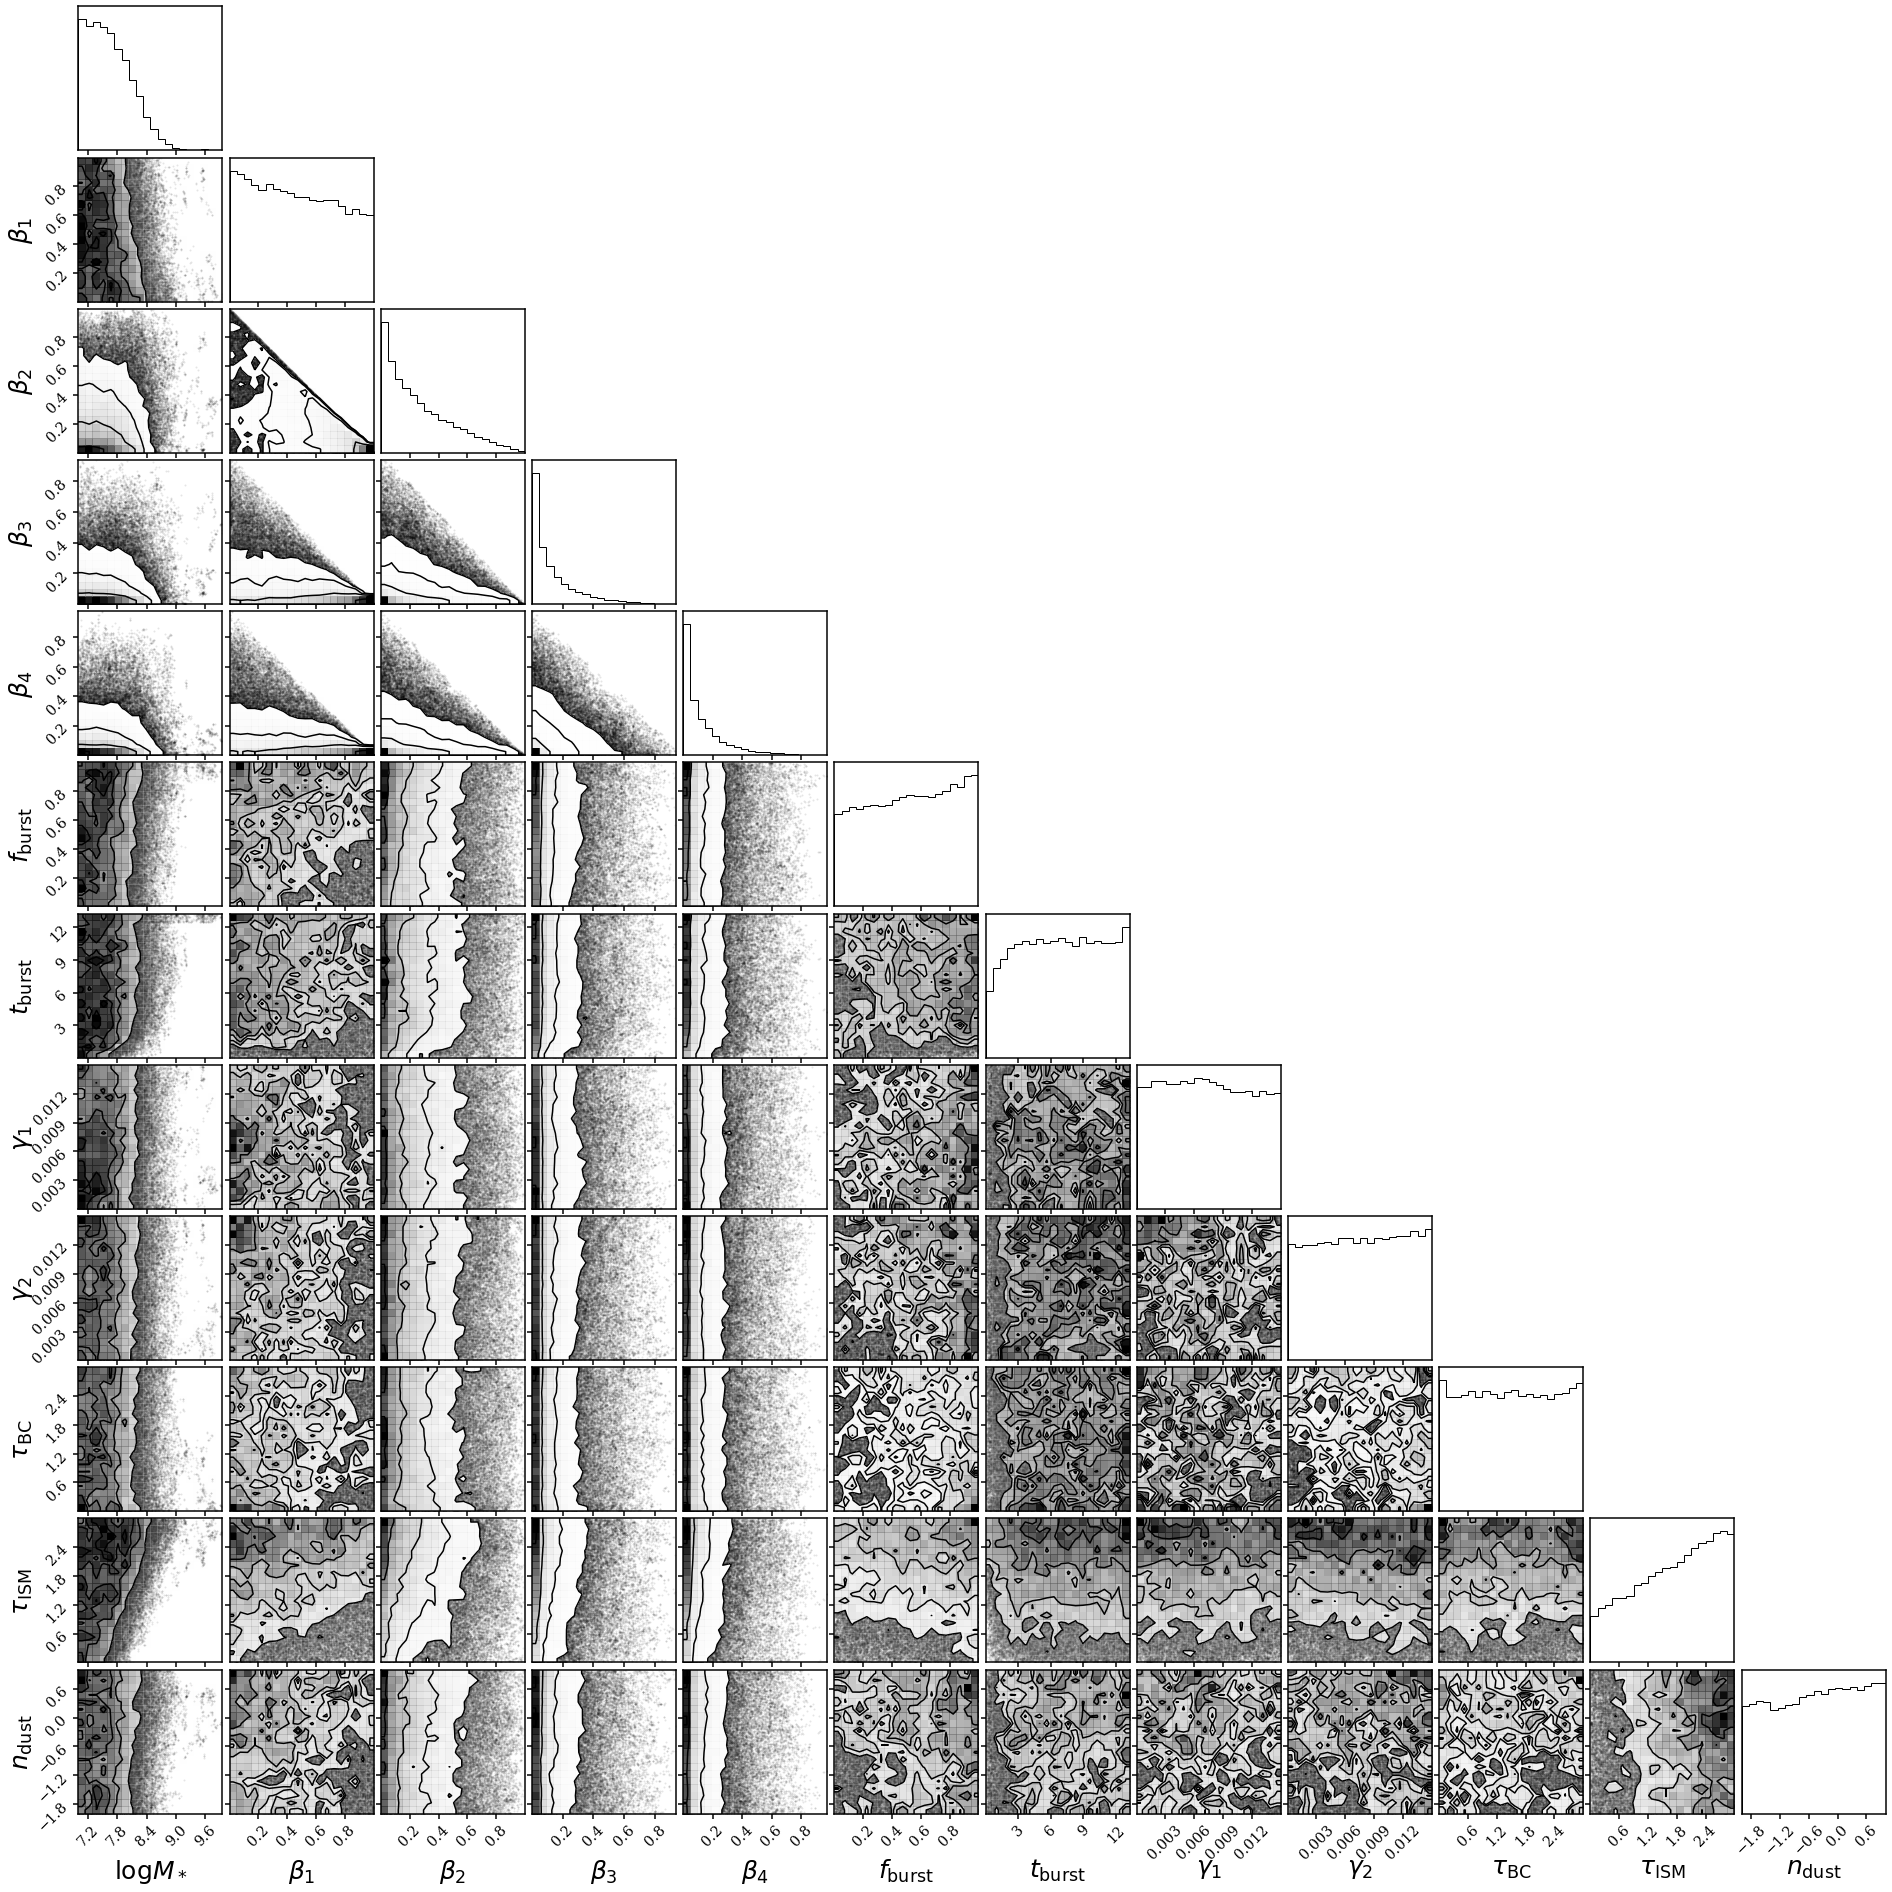

In [23]:
fig = DFM.corner(UT.flatten_chain(chain['mcmc_chain']), 
                labels=[r'$\log M_*$', r'$\beta_1$',  r'$\beta_2$',  r'$\beta_3$',  r'$\beta_4$', 
                       r'$f_{\rm burst}$', r'$t_{\rm burst}$', r'$\gamma_1$', r'$\gamma_2$', r'$\tau_{\rm BC}$', r'$\tau_{\rm ISM}$', r'$n_{\rm dust}$'],
                label_kwargs={'fontsize': 25})

Now what if you're interested in physical properties of galaxies, instead of only the SPS model parameters? The SPS model object has built in methods to calclulate physical properties.

In [24]:
# calculate SFR averaged over the last 1Gyr
avg_sfr = m_nmf.avgSFR(
    UT.flatten_chain(chain['mcmc_chain']), # posterior samples of the SPS parameters
    zred=0.1, # redshift of spectra
    dt=1) # Gyr

In [28]:
# calculate mass-weighted metallicity
Z_mw = m_nmf.Z_MW(    
    UT.flatten_chain(chain['mcmc_chain']), # posterior samples of the SPS parameters
    zred=0.1) # redshift of spectra

In [29]:
# calculate mass-weighted stellar age
tage_mw = m_nmf.tage_MW(    
    UT.flatten_chain(chain['mcmc_chain']), # posterior samples of the SPS parameters
    zred=0.1) # redshift of spectra

Next, we can look at the posteriors over these physical properties, which provides an accurate estimate of the uncertainties and degeneracies.

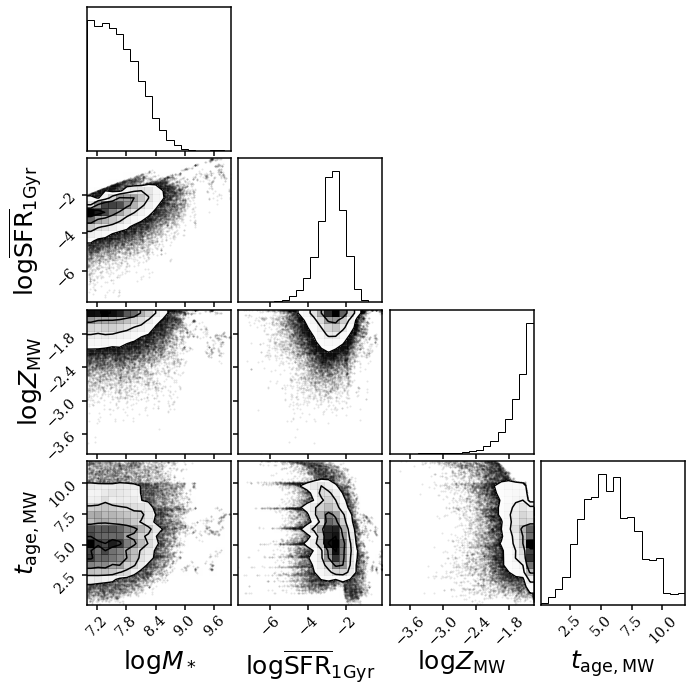

In [30]:
fig = DFM.corner(np.vstack([UT.flatten_chain(chain['mcmc_chain'])[:,0], np.log10(avg_sfr), np.log10(Z_mw), tage_mw]).T, 
                labels=[r'$\log M_*$', r'$\log \overline{\rm SFR}_{\rm 1Gyr}$', r'$\log Z_{\rm MW}$', r'$t_{\rm age, MW}$'],
                label_kwargs={'fontsize': 25})